# Continue Training LSTM w/ GPU w/ npz

- Data preprocessing was done by other [notebook](https://www.kaggle.com/seungmoklee/lstm-preprocessing-point-picker).
- I need to train more!
- Let's use GPU!

In [1]:
# Data I/O and preprocessing
import numpy as np

# System
import time
import os
import gc
from IPython.display import FileLink

# Graphic
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

import tensorflow as tf
import random
from keras import backend as K

# Global Setting

In [2]:
# directory
model_dir = "/kaggle/input/icecubemodels/"
data_dir = "/kaggle/input/icecubedata/"

In [3]:
# data
# available: 412 ~ 419
train_batch_ids = [416, 417, 418]

# training
validation_split = 0.05
seed = 220429
epochs = 10
batch_size = 128
fit_verbose = 1

learning_rate = 1e-4

In [4]:
# data preprocessing
point_picker_format = data_dir + './pointpicker_mpc128_n9_batch_{batch_id:d}.npz'

# model
prev_model_name = "PointPicker_mpc128bin16_LSTM160DENSE0"
prev_model_path = model_dir + prev_model_name
model_output_path = "./" + prev_model_name + "_10epc1e-4"

In [5]:
print(f"SEED {seed:d}")

tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

SEED 220429


# Load previous model

In [6]:
model = tf.keras.models.load_model(prev_model_path)

model.summary()

2023-02-01 19:32:33.355593: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 320)               217600    
_________________________________________________________________
dense (Dense)                (None, 256)               82176     
Total params: 299,776
Trainable params: 299,776
Non-trainable params: 0
_________________________________________________________________


In [7]:
max_pulse_count = model.inputs[0].shape[1]
n_features = model.inputs[0].shape[2]
output_bins = model.layers[-1].weights[0].shape[-1]

bin_num = int(np.sqrt(output_bins))

print("    bin_num    : ", bin_num)
print("max_pulse_count: ", max_pulse_count)
print("   n_features  : ", n_features)

    bin_num    :  16
max_pulse_count:  128
   n_features  :  9


# Prepare Metric

## Scoring functions

In [8]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

## Angle One-hot Encoding

- azimuth and zenith are independent
- azimuth distribution is flat and zenith distribution is sin
  - Flat on the spherical surface
  - $\phi > \pi$ events are a little bit rarer than $\phi < \pi$ events, (maybe) because of the neutrino attenuation by earth.
- So, the uniform bin is used for azimuth, and $\left| \cos \right|$ bin is used for zenith

In [9]:
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
zenith_edges_flat = np.linspace(0, np.pi, bin_num + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    # cos(zen_before) - cos(zen_now) = 2 / bin_num
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num))
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

In [10]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = bin_num * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, bin_num * bin_num))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

## Define a function converts from prediction to angles

- Calculation of the mean-vector in a bin $\theta \in ( \theta_0, \theta_1 )$ and $\phi \in ( \phi_0, \phi_1 )$
  - $\vec{r} \left( \theta, ~ \phi \right) = \left< \sin \theta \cos \phi, ~ \sin \theta \sin \phi, ~ \cos \theta \right>$
  - $\bar{\vec{r}} = \frac{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \vec{r} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta }{ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta }$
  - $ \int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} 1 \sin \theta \,d\phi \,d\theta = \left( \phi_1 - \phi_0 \right) \left( \cos \theta_0 - \cos \theta_1 \right)$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{x} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \cos \phi \,d\phi \,d\theta = 
\left( \sin \phi_1 - \sin \phi_0 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{y} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin^2 \theta \sin \phi \,d\phi \,d\theta = 
\left( \cos \phi_0 - \cos \phi_1 \right) \left( \frac{\theta_1 - \theta_0}{2} - \frac{\sin 2 \theta_1 - \sin 2 \theta_0}{4} \right)
$
  - $
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} {r}_{z} \left( \theta, ~ \phi \right) \sin \theta \,d\phi \,d\theta = 
\int_{\theta_{0}}^{\theta_{1}} \int_{\phi_0}^{\phi_1} \sin \theta \cos \theta \,d\phi \,d\theta = 
\left( \phi_1 - \phi_0 \right) \left( \frac{\cos 2 \theta_0 - \cos 2 \theta_1}{4} \right)
$

In [11]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

In [12]:
def pred_to_angle(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, bin_num * bin_num, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    return azimuth, zenith

# Read Feature Data

## Read feature data for training

In [13]:
print("Reading training data...")

train_x = None
train_y = None
for batch_id in tqdm(train_batch_ids):
    train_data_file = np.load(point_picker_format.format(batch_id=batch_id))
    
    if train_x is None:
        train_x = train_data_file["x"]
        train_y = train_data_file["y"]
    else:
        train_x = np.append(train_x, train_data_file["x"], axis=0)
        train_y = np.append(train_y, train_data_file["y"], axis=0)
        
    train_data_file.close()
    del train_data_file
    _ = gc.collect()

Reading training data...


100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


# Data Preprocessing

## Rough Normalization and One-hot Encoding

- Time $\div$ 1000 ns -> time `[0, 3]`
- Charge $\div$ 300 -> charge `[0, 2.5]`
- $\left( X,~Y,~Z \right) \div$ 600 m -> space `[-1, 1]`
  - their errors as well

In [14]:
train_x[:, :, 0] /= 1000  # time
train_x[:, :, 1] /= 300  # charge
train_x[:, :, 3:] /= 600  # space

train_y_onehot = y_to_onehot(train_y)

## Split validation samples

In [15]:
num_valid = int(validation_split * len(train_x))

valid_x = train_x[-num_valid:]
valid_y = train_y[-num_valid:]
valid_y_onehot = train_y_onehot[-num_valid:]

train_x = train_x[:-num_valid]
train_y = train_y[:-num_valid]
train_y_onehot = train_y_onehot[:-num_valid]

In [16]:
print(f"{'data':16s}" + f"{'shape':24s}" + f"{'mem [MB]':8s}")
print(f"{'train_x':16s}" + f"{str(train_x.shape):24s}" + f"{train_x.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'train_y':16s}" + f"{str(train_y.shape):24s}" + f"{train_y.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'train_y_onehot':16s}" + f"{str(train_y_onehot.shape):24s}" + f"{train_y_onehot.nbytes / 1024 / 1024:.4f}"[:8])
print("-" * (16 + 24 + 8))
print(f"{'valid_x':16s}" + f"{str(valid_x.shape):24s}" + f"{valid_x.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'valid_y':16s}" + f"{str(valid_y.shape):24s}" + f"{valid_y.nbytes / 1024 / 1024:.4f}"[:8])
print(f"{'valid_y_onehot':16s}" + f"{str(valid_y_onehot.shape):24s}" + f"{valid_y_onehot.nbytes / 1024 / 1024:.4f}"[:8])
print("-" * (16 + 24 + 8))
total = (train_x.nbytes + train_y.nbytes + train_y_onehot.nbytes + valid_x.nbytes + valid_y.nbytes + valid_y_onehot.nbytes) / 1024 / 1024
print(f"{'total':16s}" + f"{'':24s}" + f"{total:.4f}"[:8])
print("        real RAM usage can be doubled...")

data            shape                   mem [MB]
train_x         (570000, 128, 9)        1252.441
train_y         (570000, 2)             2.1744
train_y_onehot  (570000, 256)           1113.281
------------------------------------------------
valid_x         (30000, 128, 9)         65.9180
valid_y         (30000, 2)              0.1144
valid_y_onehot  (30000, 256)            58.5938
------------------------------------------------
total                                   2492.523
        real RAM usage can be doubled...


# Train Model

In [17]:
# update learning rate
K.set_value(model.optimizer.learning_rate, learning_rate)

In [18]:
# train model
history = model.fit(
    train_x, train_y_onehot,
    validation_data=(valid_x, valid_y_onehot),
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbose,
)

2023-02-01 19:33:11.822135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
4454/4454 [==============================] - 2146s 481ms/step - loss: 4.6661 - accuracy: 0.1242 - val_loss: 4.6358 - val_accuracy: 0.1284
Epoch 2/10
4454/4454 [==============================] - 1958s 440ms/step - loss: 4.6460 - accuracy: 0.1276 - val_loss: 4.6298 - val_accuracy: 0.1301
Epoch 3/10
4454/4454 [==============================] - 2276s 511ms/step - loss: 4.6365 - accuracy: 0.1293 - val_loss: 4.6292 - val_accuracy: 0.1307
Epoch 4/10
4454/4454 [==============================] - 2197s 493ms/step - loss: 4.6296 - accuracy: 0.1306 - val_loss: 4.6240 - val_accuracy: 0.1307
Epoch 5/10
4454/4454 [==============================] - 2241s 503ms/step - loss: 4.6239 - accuracy: 0.1316 - val_loss: 4.6230 - val_accuracy: 0.1305
Epoch 6/10
4454/4454 [==============================] - 2230s 501ms/step - loss: 4.6189 - accuracy: 0.1323 - val_loss: 4.6216 - val_accuracy: 0.1299
Epoch 7/10
4454/4454 [==============================] - 2210s 496ms/step - loss: 4.6144 - accuracy: 0.1330

## Save Model

In [19]:
%%time
print("Saving model...")
print(model_output_path)

model.save(model_output_path)

Saving model...
./PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4


2023-02-02 01:34:55.129159: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


CPU times: user 13.1 s, sys: 887 ms, total: 14 s
Wall time: 14 s


# Enable file download

In [20]:
print(model_output_path)

print(os.listdir(model_output_path))

try:
    print("assets: ", os.listdir(model_output_path + "/assets"))
except:
    print("no dir")
    
try:
    print("variables: ", os.listdir(model_output_path + "/variables"))
except:
    print("no dir")

./PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4
['assets', 'keras_metadata.pb', 'variables', 'saved_model.pb']
assets:  []
variables:  ['variables.data-00000-of-00001', 'variables.index']


In [21]:
FileLink(model_output_path + "/variables/variables.index")

/kaggle/working/PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4/variables/variables.index

In [22]:
FileLink(model_output_path + "/variables/variables.data-00000-of-00001")

/kaggle/working/PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4/variables/variables.data-00000-of-00001

In [23]:
FileLink(model_output_path + "/keras_metadata.pb")

/kaggle/working/PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4/keras_metadata.pb

In [24]:
FileLink(model_output_path + "/saved_model.pb")

/kaggle/working/PointPicker_mpc128bin16_LSTM160DENSE0_10epc1e-4/saved_model.pb

## Draw training progress

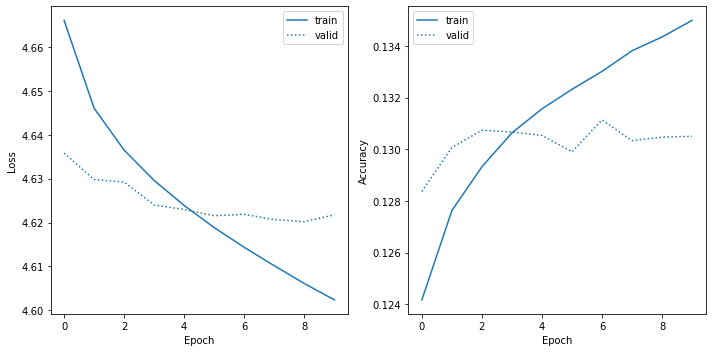

In [25]:
fig = plt.figure(figsize=(10, 5))

# history - loss
ax = plt.subplot(121)
line = ax.plot(history.epoch, history.history['loss'], label="train")
ax.plot(history.epoch, history.history['val_loss'], linestyle="dotted", color=line[0].get_color(), label="valid")
# ax.axhline(np.log(bin_num * bin_num), color="gray", label="random")

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()

# history - accuracy
ax = plt.subplot(122)
line = ax.plot(history.epoch, history.history['accuracy'], label="train")
ax.plot(history.epoch, history.history['val_accuracy'], linestyle="dotted", color=line[0].get_color(), label="valid")
# ax.axhline(1 / bin_num / bin_num, color="gray", label="random")

ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.legend()

plt.tight_layout()
plt.show()

## Evaluate model

In [26]:
valid_pred = model.predict(valid_x, verbose=1)

valid_pred_azimuth, valid_pred_zenith = pred_to_angle(valid_pred)

mae = angular_dist_score(valid_y[:, 0], valid_y[:, 1], valid_pred_azimuth, valid_pred_zenith)

938/938 [==============================] - 65s 69ms/step


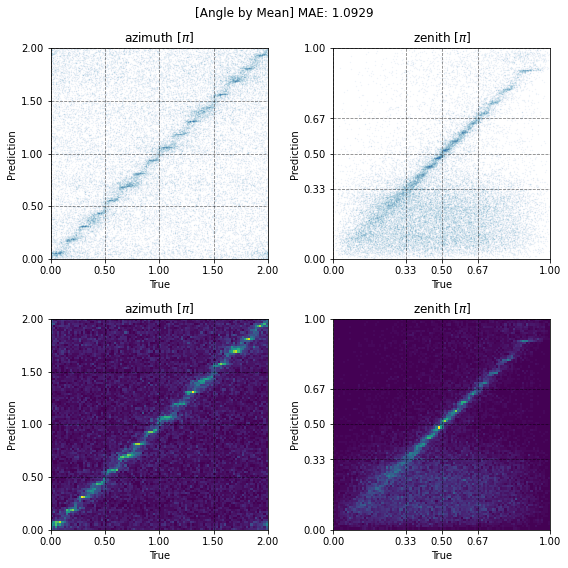

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0, 0]
ax.scatter(valid_y[:, 0], valid_pred_azimuth, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[0, 1]
ax.scatter(valid_y[:, 1], valid_pred_zenith, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

ax = axs[1, 0]
ax.hist2d(valid_y[:, 0], valid_pred_azimuth, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[1, 1]
ax.hist2d(valid_y[:, 1], valid_pred_zenith, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(bin_num//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(bin_num//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(bin_num//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

plt.suptitle(f"[Angle by Mean] MAE: {mae:.4f}")
plt.tight_layout()
plt.show()

# END-OF-NOTE